# Take the Tour

_(The tour is auto-generated from 
[this jupyter notebook](https://github.com/mar10/nutree/blob/main/docs/jupyter/take_the_tour.ipynb).)_

Nutree organizes arbitrary object instances in an unobtrusive way. <br>
That means, we can add existing objects without having to derive from a common 
base class or implement a specific protocol.

In [1]:
from nutree import Tree

tree = Tree("Hello")
tree.add("N").add("u").up(2).add("T").add("r").up().add("ee")
tree.print()

Tree<'Hello'>
├── 'N'
│   ╰── 'u'
╰── 'T'
    ├── 'r'
    ╰── 'ee'


Strings can be directly added to a tree, but in a real-world scenario we want to 
handle ordinary objects:

## Set up some sample classes and objects
Let's define a simple class hierarchy

In [2]:
import uuid


class Department:
    def __init__(self, name: str):
        self.guid = uuid.uuid4()
        self.name = name

    def __str__(self):
        return f"Department<{self.name}>"


class Person:
    def __init__(self, name: str, age: int):
        self.guid = uuid.uuid4()
        self.name = name
        self.age = age

    def __str__(self):
        return f"Person<{self.name} ({self.age})>"

and create some instances

In [3]:
development_dep = Department("Development")
test__dep = Department("Test")
marketing_dep = Department("Marketing")

alice = Person("Alice", 25)
bob = Person("Bob", 35)
claire = Person("Claire", 45)
dave = Person("Dave", 55)

Now that we have a bunch of instances, let's organize these objects in a 
hierarchical structure using _nutree_:

In [4]:
from nutree import Tree

tree = Tree("Organization")

dev_node = tree.add(development_dep)
test_node = dev_node.add(test__dep)
mkt_node = tree.add(marketing_dep)

tree.add(alice)
dev_node.add(bob)
test_node.add(claire)
mkt_node.add(dave)

tree.print()

Tree<'Organization'>
├── <__main__.Department object at 0x105046a50>
│   ├── <__main__.Department object at 0x10d13d9d0>
│   │   ╰── <__main__.Person object at 0x10d13d1c0>
│   ╰── <__main__.Person object at 0x10d13d130>
├── <__main__.Department object at 0x10d13ccb0>
│   ╰── <__main__.Person object at 0x10d13d250>
╰── <__main__.Person object at 0x10d13cfb0>


Tree nodes store a reference to the object in the `node.data` attribute.

The nodes are formatted for display by the object's  `__repr__` implementation 
by default. <br>
We can overide this by passing an 
[f-string](https://docs.python.org/3/tutorial/inputoutput.html#formatted-string-literals) 
as `repr` argument. <br>
For example `"{node.data}"` will use the data instances `__str__` method instead:

In [5]:
tree.print(repr="{node.data}")

Tree<'Organization'>
├── Department<Development>
│   ├── Department<Test>
│   │   ╰── Person<Claire (45)>
│   ╰── Person<Bob (35)>
├── Department<Marketing>
│   ╰── Person<Dave (55)>
╰── Person<Alice (25)>


## Access Nodes
We can use the index syntax to get the node object for a given data object:

In [6]:
tree[alice]

Node<'Person<Alice (25)>', data_id=282148091>

Note that we passed `alice` as index, which is an instance of `Person`, and received an instance of the `Node` container:

In [7]:
from nutree import Node

assert isinstance(tree[alice], Node)
assert tree[alice].data is alice, "nodes store objects in data attribute"

There are other other search methods as well

In [8]:
tree.find_all(match=lambda node: "i" in node.data.name)

[Node<'Person<Claire (45)>', data_id=282148124>,
 Node<'Department<Marketing>', data_id=282148043>,
 Node<'Person<Alice (25)>', data_id=282148091>]

### Control the `data_id`

If the object instances have an attribute that naturally identifies them, 
we can use it instead of the default `hash()`. <br>
This improves readability and may be more appropriate for serialization:

In [9]:
tree_2 = Tree("Organization", calc_data_id=lambda tree, data: str(data.guid))

dep_node_2 = tree_2.add(development_dep)
dep_node_2.add(bob)

tree_2.print(repr="{node}")

Tree<'Organization'>
╰── Node<'Department<Development>', data_id=113d0d59-d0d4-4ca2-871a-41a0759e3b20>
    ╰── Node<'Person<Bob (35)>', data_id=23bb0f0a-cda2-4cb0-b73e-df12929115b1>


now we could also search by the GUID, for example:

In [10]:
tree_2.find(data_id=str(bob.guid))

Node<'Person<Bob (35)>', data_id=23bb0f0a-cda2-4cb0-b73e-df12929115b1>

## Iteration and Searching

There are multiple methods to iterate the tree.

In [11]:
res = []
for node in tree:  # depth-first, pre-order traversal
    res.append(node.data.name)
print(res)

['Development', 'Test', 'Claire', 'Bob', 'Marketing', 'Dave', 'Alice']


In [12]:
from nutree import IterMethod

res = []
for node in tree.iterator(method=IterMethod.POST_ORDER):
    res.append(node.data.name)
print(res)

['Claire', 'Test', 'Bob', 'Development', 'Dave', 'Marketing', 'Alice']


In [13]:
def callback(node, memo):
    print(node.data.name, end=", ")


tree.visit(callback, method=IterMethod.LEVEL_ORDER)

Development, Marketing, Alice, Test, Bob, Dave, Claire, 

The above traversal methods are also available for single nodes:

In [14]:
res = [node.data.name for node in dev_node]
print(res)

['Test', 'Claire', 'Bob']


## Filter

We can create a filtered copy like so:

In [15]:
tree_copy = tree.filtered(lambda node: isinstance(node.data, Department))
tree_copy.print(repr="{node}")

Tree<"Copy of Tree<'Organization'>">
├── Node<'Department<Development>', data_id=273696421>
│   ╰── Node<'Department<Test>', data_id=282148253>
╰── Node<'Department<Marketing>', data_id=282148043>


In-place filtering is also available:

In [16]:
tree_copy.filter(lambda node: "m" in node.data.name.lower())
tree_copy.print(repr="{node}")

Tree<"Copy of Tree<'Organization'>">
├── Node<'Department<Development>', data_id=273696421>
╰── Node<'Department<Marketing>', data_id=282148043>


## Mutation

We can add, copy, move, remove, sort, &hellip; nodes.

For example:

In [17]:
alice_node = tree[alice]
bob_node = tree[bob]

bob_node.move_to(mkt_node)
alice_node.copy_to(dev_node)

tree.print(repr="{node.data}")

Tree<'Organization'>
├── Department<Development>
│   ├── Department<Test>
│   │   ╰── Person<Claire (45)>
│   ╰── Person<Alice (25)>
├── Department<Marketing>
│   ├── Person<Dave (55)>
│   ╰── Person<Bob (35)>
╰── Person<Alice (25)>


Read the [user guide](https://nutree.readthedocs.io/en/latest/ug_mutation.html) 
for more ways to modify a tree.

## Data IDs and Clones

In the example above, we duplicated the 'Alice' node, so we now have two 
node instances that reference the same data object, as we can see from the
identical data_id:

In [18]:
tree.print(repr="{node}", title=False)

Node<'Department<Development>', data_id=273696421>
├── Node<'Department<Test>', data_id=282148253>
│   ╰── Node<'Person<Claire (45)>', data_id=282148124>
╰── Node<'Person<Alice (25)>', data_id=282148091>
Node<'Department<Marketing>', data_id=282148043>
├── Node<'Person<Dave (55)>', data_id=282148133>
╰── Node<'Person<Bob (35)>', data_id=282148115>
Node<'Person<Alice (25)>', data_id=282148091>


In [19]:
for clone in tree.find_all(alice):
    print(f"{clone}, parent={clone.parent}")

Node<'Person<Alice (25)>', data_id=282148091>, parent=None
Node<'Person<Alice (25)>', data_id=282148091>, parent=Node<'Department<Development>', data_id=273696421>


## Special Data Types
### Plain Strings

Plain strings are hashable objects, so we can handle them the same way as any 
other object:

In [20]:
tree_str = Tree()
a = tree_str.add("A")
a.add("a1")
a.add("a2")
tree_str.add("B")
tree_str.print()

Tree<'4514376368'>
├── 'A'
│   ├── 'a1'
│   ╰── 'a2'
╰── 'B'


### Dictionaries

We cannot add Python `dict` objects to a tree, because nutree cannot derive
a *data_id* for unhashable types. <br>
We can handle this by passing a *data_id* explicitly to `add()` and similar 
methods, or implement a `calc_data_id` callback as shown before.

As another workaround, we can wrap it inside `DictWrapper` objects:

In [21]:
from nutree import DictWrapper, Tree

d = {"title": "foo", "id": 1}

tree = Tree()
tree.add("A").up().add("B")
tree["A"].add(DictWrapper(d))
tree["B"].add(DictWrapper(d))
tree.print(repr="{node}")
# tree.find(d)

Tree<'4514376704'>
├── Node<'A', data_id=60011971360030034>
│   ╰── Node<"DictWrapper<{'title': 'foo', 'id': 1}>", data_id=4514401856>
╰── Node<'B', data_id=-4763155670598877281>
    ╰── Node<"DictWrapper<{'title': 'foo', 'id': 1}>", data_id=4514401856>


## Typed Trees

The `TypedTree` subclass adds a 'kind' attribute to the nodes, and related 
methods. <br>
This allows to organize objects in directed graphs:

In [22]:
from nutree import TypedTree

typed_tree = TypedTree()
typed_tree.add("Mia", kind="friend").add("Noah", kind="brother").up().add(
    "Olivia", kind="sister"
)
typed_tree.print()

TypedTree<'4514377616'>
╰── friend → Mia
    ├── brother → Noah
    ╰── sister → Olivia


## Serialization

Nutree supports save/load in a compact native JSON format as well as 
ZIP, RDF, DOT, and mermaid. <br>
Even conversion to and SVG, PNG is possible:

![example](../sphinx/test_mermaid_typed.png)

Read the [User Guide](https://nutree.readthedocs.io/en/latest/ug_serialize.html) 
for different methods to save, load, or convert a tree to different output formats.


## Diff

Given two trees, for example

```
Tree<'T0'>
├── Node<'Department<Development>', data_id={012-345}>
│   ├── Node<'Person<Alice, 23>', data_id={123-456}>
│   ╰── Node<'Person<Bob, 32>', data_id={234-456}>
╰── Node<'Department<Marketing>', data_id={012-456}>
    ├── Node<'Person<Charleen, 43>', data_id={345-456}>
    ╰── Node<'Person<Dave, 54>', data_id={456-456}>

Tree<'T1'>
├── Node<'Department<Development>', data_id={012-345}>
│   ╰── Node<'Person<Newman, 67>', data_id={567-567}>
╰── Node<'Department<Marketing>', data_id={012-456}>
    ├── Node<'Person<Alicia, 23>', data_id={123-456}>
    ├── Node<'Person<Charleen, 43>', data_id={345-456}>
    ╰── Node<'Person<Dave, 55>', data_id={456-456}>
```

We can generate a merged tree with additional annotations:

```py
tree_2 = tree_0.diff(tree_1, compare=True, reduce=False)
tree_2.print(repr=diff_node_formatter)
```

```
Tree<"diff('T0', 'T1')">
├── Department<Development>
│   ├── Person<Newman, 67> - [Added]
│   ├── Person<Alice, 23> - [Moved away]
│   ╰── Person<Bob, 32> - [Removed]
╰── Department<Marketing>
    ├── Person<Alicia, 23> - [Moved here], [Modified]
    ├── Person<Charleen, 43>
    ╰── Person<Dave, 54> - [Modified]
```

It is also possible to visualize as png, for example:
```py
tree_2.to_dotfile("tree_diff.png", format="png", ...)
```

![image.png](../sphinx/test_graph_diff_2.png)

## Type Hints

Nutree comes fully typed (passing [pyright](https://microsoft.github.io/pyright/#/) 
standard checks). This improves type-safety and auto-complete features inside 
IDEs.

Assuming we have a hierrchy of objects:

In [23]:
class OrgaEntry:
    def __init__(self, name: str):
        self.name: str = name
        self.guid = uuid.uuid4()


class Person(OrgaEntry):
    def __init__(self, name: str, age: int):
        super().__init__(name)
        self.age: int = age


class Department(OrgaEntry):
    def __init__(self, name: str):
        super().__init__(name)

We can now create a type-safe tree to store these objects:

In [24]:
tree = Tree[OrgaEntry]()

dev = tree.add(Department("Development"))
alice = dev.add(Person("Alice", 25))

tree.add(12345)  # Flags a typing error in the IDE (but not at runtime)

# IDE infers that the type `OrgaEntry` is stored in the `data` attribute
# and provides code completion
print(alice.data.guid)

tree.add

b6967ba9-2345-46ec-9bd8-72e1a5cfdf8f


<bound method Tree.add of Tree<'4514378672'>>

Note that the IDE can now **make better suggestions**

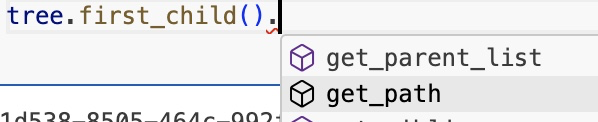

**display type info**

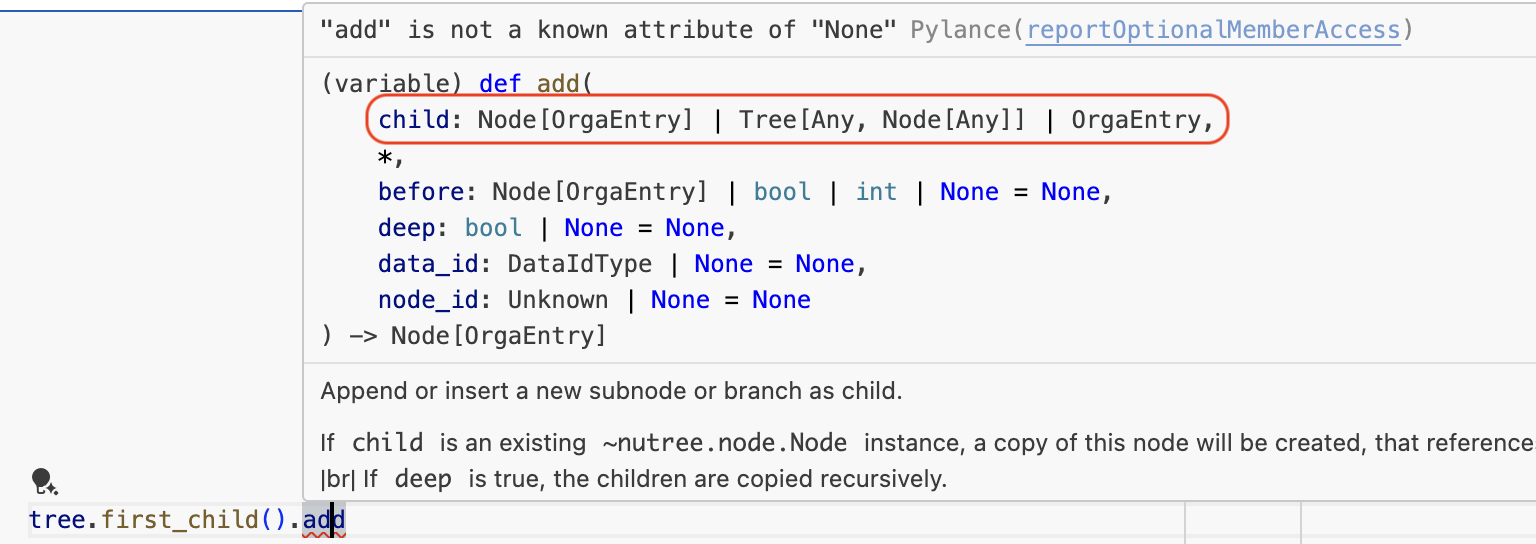

and **detect type errors**:

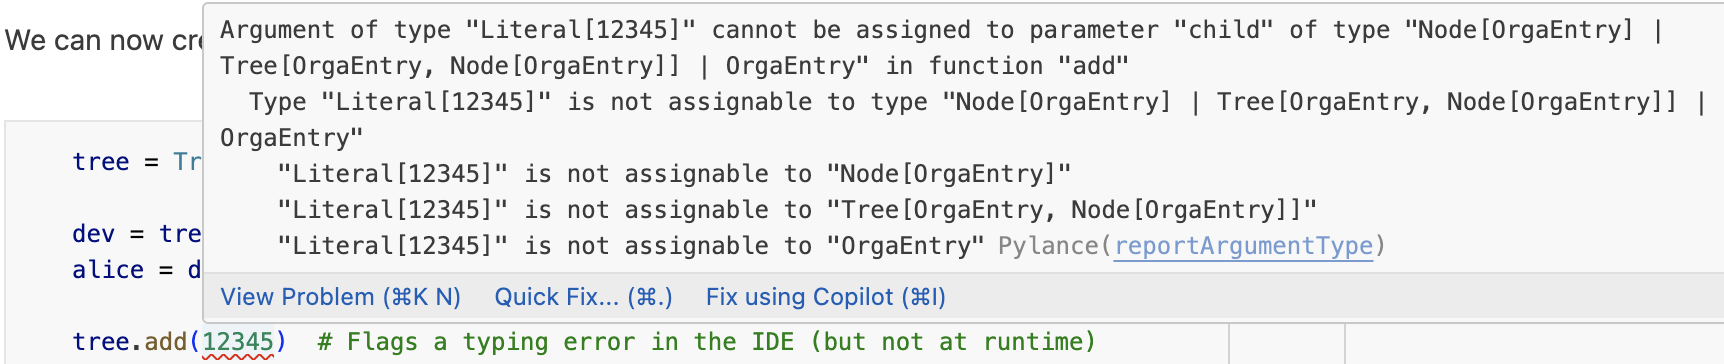